In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0 pyspark-shell'

In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
import operator
import numpy as np

In [5]:
confg = SparkConf().setMaster("local[2]").setAppName("TwitterStreamer")
sc = SparkContext(conf=confg)

In [6]:
ssc = StreamingContext(sc, 5)
ssc.checkpoint("checkpoint")
sqlContext = SQLContext(sc)

In [7]:
def load_wordlist(filename):
    """ 
    This function returns a list or set of words from the given filename.
    """	
    words = {}
    f = open(filename)
    text = f.read()
    text = text.split('\n')
    for line in text:
        words[line] = 1
    f.close()
    return words

In [8]:
pwords = load_wordlist("positive.txt")
nwords = load_wordlist("negative.txt")
#for i in pwords:
 #   print(i)

In [9]:
kstream = KafkaUtils.createDirectStream(ssc, topics = ['twitterstream'], kafkaParams = {"bootstrap.servers": "localhost:9092"})

Py4JJavaError: An error occurred while calling o32.createDirectStreamWithoutMessageHandler.
: org.apache.spark.SparkException: java.nio.channels.ClosedChannelException
	at org.apache.spark.streaming.kafka.KafkaCluster$$anonfun$checkErrors$1.apply(KafkaCluster.scala:387)
	at org.apache.spark.streaming.kafka.KafkaCluster$$anonfun$checkErrors$1.apply(KafkaCluster.scala:387)
	at scala.util.Either.fold(Either.scala:98)
	at org.apache.spark.streaming.kafka.KafkaCluster$.checkErrors(KafkaCluster.scala:386)
	at org.apache.spark.streaming.kafka.KafkaUtils$.getFromOffsets(KafkaUtils.scala:223)
	at org.apache.spark.streaming.kafka.KafkaUtilsPythonHelper.createDirectStream(KafkaUtils.scala:721)
	at org.apache.spark.streaming.kafka.KafkaUtilsPythonHelper.createDirectStreamWithoutMessageHandler(KafkaUtils.scala:689)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [26]:
def getsentiment(word):
    if word in pwords:
        return ("POSITIVE",50)
    elif word in nwords:
        return ("NEGATIVE",50)
    else :
        return ("NEUTRAL",1)

In [27]:
from collections import namedtuple
fields = ("sentiment", "value" )
Tweet = namedtuple( 'Tweet', fields )

In [28]:
tweets = kstream.map(lambda x: x[1])
#tweets.pprint()
#words = tweets.flatMap(lambda line:line.split(" ")).map(lambda word: (word, 1)).reduceByKey(lambda a, b: a+b)
#words.pprint()
(tweets.flatMap( lambda text: text.split( " " ) ).map(getsentiment).reduceByKey( lambda a, b: a + b ).map( lambda rec: Tweet( rec[0], rec[1] ) ).foreachRDD( lambda rdd: rdd.toDF().sort( desc("value") ).limit(10).registerTempTable("tweets")) )  

In [29]:
#words = tweets.flatMap(lambda line:line.split(" "))
#positive = words.map(lambda word: ('Positive', 1) if word in pwords else ('Positive', 0))
#negative = words.map(lambda word: ('Negative', 1) if word in nwords else ('Negative', 0))
#neutral = words.map(lambda word: ('Neutral', 1) if word not in pwords and nwords else ('Neutral', 0))
#allSentiments = positive.union(negative.union(neutral))
#sentimentCounts = allSentiments.reduceByKey(lambda x,y: x+y)


In [30]:
#counts = []
#sentimentCounts.foreachRDD(lambda t, rdd: counts.append(rdd.collect()))

In [31]:
ssc.start()

In [32]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
# Only works for Jupyter Notebooks!
%matplotlib inline

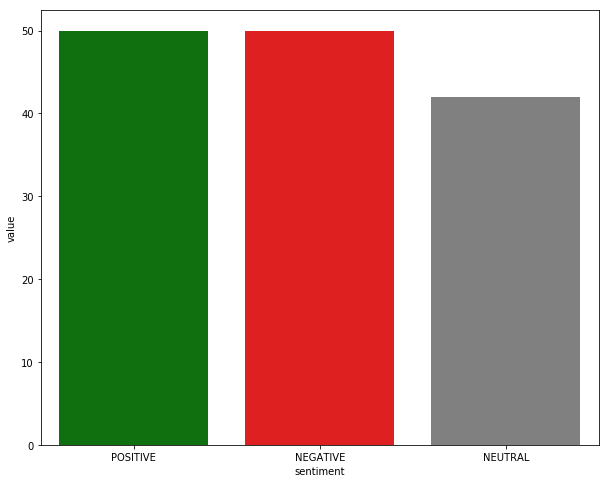

In [ ]:
count = 0
while count < 100:
    time.sleep(3)
    top_3_tweets = sqlContext.sql( "Select sentiment, value from tweets" )
    #top_3_tweets.select(['sentiment','value']).show()
    top_3_df = top_3_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    palette ={"POSITIVE":"green","NEGATIVE":"red","NEUTRAL":"grey"}
    sns.barplot( x="sentiment", y="value", data=top_3_df, palette=palette)
    plt.show()
    count = count + 1

In [18]:
ssc.stop()

In [55]:
# positiveCounts = []
# negativeCounts = []
# neutralCounts = []
# time = []

# for val in counts:
#     positiveTuple = val[0]
#     positiveCounts.append(positiveTuple[1])
#     negativeTuple = val[1]
#     negativeCounts.append(negativeTuple[1])
#     neutralTuple = val[2]
#     neutralCounts.append(neutralTuple[1])

# for i in range(len(counts)):
#     time.append(i)

# posLine = plt.plot(time, positiveCounts,'go-', label='Positive')
# negLine = plt.plot(time, negativeCounts,'ro-', label='Negative')
# neuLine = plt.plot(time, neutralCounts,'bo-', label='Neutral')
# plt.axis([0, len(counts), 0, max(max(positiveCounts), max(max(negativeCounts), max(neutralCounts)))+50])
# plt.xlabel('Time step')
# plt.ylabel('Word count')
# plt.legend(loc = 'upper left')
# plt.show()